# Application 2: Train our baseline model (DeBERTa)

Finally, it is time to train our model and solve our classification task. We will 
1. train our classifier based on the [DeBERTa small](https://huggingface.co/microsoft/deberta-v3-small/tree/main) model.
2. visualize our results in form of confusion matrix, roc curve and certainty of classifier. 

The model is trained on GPUs. Thus, you need to make sure that you run this notebook with GPU support. For this, create a new [JupyterLabs session](https://jupyter-jsc.fz-juelich.de/hub/home) and pick a `Partition` with GPU support like "gpus" or "develgpus". 1 Node will suffice for training our model.

## Exercise 0: Gain a basic understanding of BERT and its derivatives
Generally, our problem can be phrased as a text classification task, where deep learning models based on the transformer architecture (Vaswani et al. 2017) achieve state-of-the-art results (e.g., Yang et al. 2019). Transformers use self-attention to attribute varying relevance to different parts of the text. Based on transformers the BERT model was developed (Devlin et al. 2019), which includes crucial pre-training steps to familiarise the model with relevant vocabulary and semantics. In addition, the DeBERTa model (He et al. 2021a) adds additional pre-training steps and disentangles how positional and text information is stored in the model to improve performance. For this experiment we rely on the most recent version of the model, which is DeBERTaV3 (He et al. 2021b).
We use the default version of DeBERTaV3_small as described in He et al. 2021b with an adopted head for text classification. For this, we add a dropout layer with user-specified dropout rate and a pooling layer that passes the embedding of the special initial token ([CLS], comprising the meaning of the whole Tweet) to the loss function.

To gain a deeper insight into "self-attention", BERT and DeBERTa, I provide you with a presentation discussing the project, which goes into great detail to explain these concepts. The slide can be found [here](https://docs.google.com/presentation/d/1hW4_wLj0QIEhFQdKqVj6Uep2fWMqrbeek_5IjOUXeCQ/edit?usp=sharing) but I will also give the presentation at the beginning of the session. 

## Tasks:
* Ask at least one "dumb" and one "smart" question during the presentation :-)

## Exercise 1: Package overview
We will use the [Hugging Face](https://huggingface.co/docs/transformers/index) for training our DeBERTa model. The library contains a plethora of [pre-trained models](https://huggingface.co/models) that can easily be [accessed](https://huggingface.co/docs/transformers/autoclass_tutorial) (including tokenization), modified for your task (used for classification, next sentence predicition, etc.) and [fine-tuned](https://huggingface.co/docs/transformers/training) for your use case. 

For reference, the saved pretrained weights of the "small" DeBERTa version can be found [here](https://huggingface.co/microsoft/deberta-v3-small) (which corresponds to our best model currently) and the model documentation/ implementation details [here](https://huggingface.co/docs/transformers/model_doc/deberta-v2).

However, we will go through setting up the model together step by step. Let's start by importing all relevant packages. Besides modules from the Hugging Face library. We are importing modules from [scikit-learn](https://scikit-learn.org/stable/), which is a popular library that we use for splitting our dataset and analyze our results. In addition, we use [PyTorch](https://pytorch.org/), which is low leve (compared to Hugging Face) library that can be used to build deep learning models from scratch. Here, we just use it to test if the notebook has access to gpus and to compute some metrics.

Tasks:
* Execute the following cell to import all required packages.  
  If you encounter any errors, make sure you are using the correct ipython kernel. If you cannot fix the issue yourself, do not "waste" your time and quickly approach a tutor for help!

In [1]:
# !jupyter kernelspec list

In [1]:
# may take some time ...
import sys
import pathlib
import string
import re
import os
import logging
import functools

# location of scripts folder for bootcamp
sys.path.append("../scripts")
import normalize_text_bootcamp
import utils_bootcamp
import plotting

logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray

# Pytorch modules
import torch
import torch.nn.functional

# scikit-learn modules
import sklearn.metrics
import sklearn.model_selection

# "Hugging Face" modules
import datasets
import transformers

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exercise 2: Small intro to using and monitoring GPUs on HPC
We will now take a look at how to 
1. check if our training functions can "see" GPUs. For this and the next task we will use pytorch 
2. reset the GPU memory. This can be useful when you use the same module to train another version of the model. As the memory may not automatically reset especially when you encounter a crash while training....
3. monitor GPU recources like processing power and memory. Functionality for this is built into our jupyter environment.

## Tasks:
* Use `[torch.cuda.device(i) for i in range(torch.cuda.device_count())]` to check if PyTorch and therefore the Hugging Face library, which we will use for training has access to your GPUs. You should see 4 devices (a node contains 4 GPUs). 

    If it returns an empty list, make sure you picked a `Partition` that includes GPUs when setting up JupyterLabs. If the problem persists, again try to approach a tutor as this can "waste" considerable amount of your time and access to GPUs is crucial for the rest of the week.
* To reset the memory use `torch.cuda.empty_cache()`. Not much is gonna change visibly but the next task is gonna change that.
* JupyterLabs comes by default with monitoring tools. They can be found in the left toolbar. Click on the fourth symbol from the top called `System Dashboards`. A menu should open, where you should now double-click `GPU Utilization`. This which should open up a new tab in your JupyterLabs session, which shows the load on your GPUs, which should basically be zero as we are currently not employing any GPUs. Patience, may be required when opening these tools as they can take some time to load and update. Go back to the menu and also open `GPU Memory`, which gives an overview of allocated GPU memory. This can help you debug your code when you run into memory issues. Finally, we open `GPU Resources`, which provides you with a concise overview of GPU utilization, memory and communication. 


In [2]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

## Exercise 3: Loading and splitting the data
We load the data and split the data into a training set, which we use for training the model and a test set, which is set a side during training and used to analyze the efficacy of the model. This procedure comes with the benefit that we automatically control for overfitting.  We use `sklearn.model_selection.train_test_split` to split the dataset. However, we will not literally split the dataset in two but rather use two sets of indices `indices_train` and `indices_test` to later select the desired part of the dataset for either training or analyzing, respectively. We would like to 'stratify' our train and test set, which allows us to uphold the same fraction of labels in the test and training set, which reduces biases. 

## Tasks:
* Load the SMALL dataset (with filtered and normalized Tweets) (saved as '/p/project/training2223/a2/data/tweets/tweets_2017_era5_normalized_filtered.nc') with xarray and assign it to variable `ds_raw`.
* Obtain indices for the training (80% of dataset) and test set (20% of dataset), while stratifying the sets based on our label (presence of rain at time/location of Tweet). Use the code fragment below to get started and have a look at the [documentation of the function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 
* Plot a histogram of the distribution of the labels in the training and test set. Do they follow the same distribution?

In [3]:
# ds_tweets = ...
FOLDER_DATA = "/p/project/deepacf/maelstrom/haque1/dataset/"
FOLDER_TWEET = FOLDER_DATA + "tweets_2017_01_era5_normed_filtered.nc"
ds_tweets = xarray.load_dataset(FOLDER_TWEET)

In [4]:
# again define labels
key_tp = "tp_h"
ds_tweets["raining"] = (["index"], ds_tweets[key_tp].values > 1e-8)

In [7]:
indices_train, indices_test = sklearn.model_selection.train_test_split(
    np.arange(ds_tweets["index"].shape[0]),
    random_state=42,
    shuffle=True,
    test_size=0.2,
    stratify=ds_tweets["raining"].values
)

In [8]:
indices_train, indices_test

(array([ 5429,  8312, 22578, ...,  9508, 12305, 20613]),
 array([ 5494,  2873, 18559, ..., 17130,  2040, 20124]))

## Exercise 4: Load the tokenizer and bring the data into the expected format by Hugging Face
We will load the pretrained tokenizer that will be used to convert our Tweets to 'arrays of numbers' and introduce a dictionary to store the dataset to be usable by the Hugging Face training function. The following tasks are quite guided as there are more exciting parts of training.

## Tasks:

* Prepare our dataset for training by tokenizing Tweets and converting into the expected data format. Just executing the following lines should do the trick.

In [7]:
# load the pretrained tokenizer
model_nm = "/p/project/deepacf/maelstrom/haque1/deberta-v3-small"  # model repo downloaded from Hugging Face to the cluster

tokenizer = transformers.AutoTokenizer.from_pretrained(model_nm)
db_config_base = transformers.AutoConfig.from_pretrained(model_nm, num_labels=2)

/transformers/src/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
# define functions to convert the dataset to a format that is used by Hugging Face


def tok_func(x, tokenizer):
    """
    tokenizes the field 'inputs' stored in x including padding
    """
    return tokenizer(x["inputs"], padding=True)


def get_dataset(ds, tok_func, tokenizer, indices_train, indices_test, train=True):
    """
    converts dataset to 'dataset' format required by Hugging Face

    Parameters:
    ----------
    ds: dataset
    tok_func: functiond use for tokenization
    indices_train: indices corresponding to the training set
    indices_test: indices corresponding to the training set
    train: if used for training

    Returns
    -------
    header of file
    """
    # converting dataset to pandas as Hugging Face datasets has inbuilt function that converts pandas dataframe to a Hugging Face dataset
    df = ds[["text_normalized", "raining"]].to_pandas()
    df = df.rename(columns={"text_normalized": "inputs"})
    df = df.rename(columns={"raining": "label"})
    datasets_ds = datasets.Dataset.from_pandas(df)
    tok_function_partial = functools.partial(tok_func, tokenizer=tokenizer)
    tok_ds = datasets_ds.map(tok_function_partial, batched=True)
    if train:
        return datasets.DatasetDict(
            {"train": tok_ds.select(indices_train), "test": tok_ds.select(indices_test)}
        )
    else:
        return tok_ds

In [9]:
# create Hugging Face 'dataset'
dataset = get_dataset(ds_tweets, tok_func, tokenizer, indices_train, indices_test)

Map: 100%|██████████| 24491/24491 [00:00<00:00, 24647.57 examples/s]


## Exercise 5: Define parameters and functions used for actual training step 

In the following we will define our default values for our hyper parameters. Some of these parameters are model independent and others specific to the model. While documentation for model independent parameters can found [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments), model dependant paramters can be found on the [dedicated page](https://huggingface.co/docs/transformers/model_doc/deberta#transformers.DebertaConfig), which can be a bit confusing.

* learning_rate = 8e-5
* batch_size = 16
* weight_decay = 0.01
* epochs = 1
* warmup_ratio = 0.1
* cls_dropout = 0.3
* lr_scheduler_type = "cosine"

Task:
* Define your personal folder where Hugging Face should save trained weights and debugging information as `FOLDER_TO_OUTPUT`. This folder tends to be quite large and may overwrite results of your colleaques, so make sure it's in your personal directory.
* Execute cells below and try to get a first impression of what these functions are doing. For example, by reading their docstring.
* We are using the f1 score as our main metric. How is it computed and why is considered more 'useful' than accuracy for example? We compute the f1-score of 'raining' and not 'raining', which one is more instructive for model performance? Let's discuss!

In [10]:
# we define our hyper-parameters in a dictionary `parameters`
parameters = {}
parameters["learning_rate"] = 8e-5
parameters["batch_size"] = 16
parameters["weight_decay"] = 0.01
parameters["epochs"] = 1
parameters["warmup_ratio"] = 0.1
parameters["cls_dropout"] = 0.3
parameters["lr_scheduler_type"] = "cosine"

FOLDER_TO_OUTPUT  = "/p/project/deepacf/maelstrom/haque1/model/"

In [11]:
def get_model(params, db_config_base, model_nm):
    """
    function to retrieve model, format follows Hugging Face convention (parameter -> 'params')
    """
    db_config = db_config_base
    if params is not None:
        db_config.update({"cls_dropout": params["cls_dropout"]})
    db_config.update({"num_labels": 2})
    model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_nm, config=db_config
    )
    return model


def compute_metrics(eval_pred):
    """
    compute f1 metrics of both labels, format follows Hugging Face convention

    Parameters:
    ----------
    eval_pred: evaluation/test set probalities for classification task

    Returns
    -------
    dictionary returning labeled f1 score of "not raining" and "raining"
    """
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    classification_report = sklearn.metrics.classification_report(
        labels, predictions, target_names=["not raining", "raining"], output_dict=True
    )
    f1_not_raining = classification_report["not raining"]["f1-score"]
    f1_raining = classification_report["raining"]["f1-score"]
    return {"f1_not_raining": f1_not_raining, "f1_raining": f1_raining}


def get_trainer(dataset, db_config_base, model_nm, FOLDER_TO_OUTPUT, parameters):
    """
    initializes `transformers.Trainer`, which is used to train models with Hugging Face

    Hyper parameters are here assigned to model.
    Parameters:
    ----------
    dataset: dataset in format required by Hugging Face
    db_config_base: default model configurations
    model_nm: model folder
    FOLDER_TO_OUTPUT: folder where trained model, tokenizer,... will be saved
    parameters: dictionary of hyper-parameters

    Returns
    -------
    trainer with assigned parameters used for training
    """
    args = transformers.TrainingArguments(
        FOLDER_TO_OUTPUT,
        learning_rate=parameters["learning_rate"],
        warmup_ratio=parameters["warmup_ratio"],
        lr_scheduler_type=parameters["lr_scheduler_type"],
        disable_tqdm=False,
        fp16=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=parameters["batch_size"],
        per_device_eval_batch_size=parameters["batch_size"],
        num_train_epochs=parameters["epochs"],
        weight_decay=parameters["weight_decay"],
        report_to="none",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    # convert `get_model` to partial function to pass it as an argument in `transformers.Trainer`
    # see https://www.geeksforgeeks.org/partial-functions-python/ for quick tutorial
    get_model_partial = functools.partial(
        get_model, db_config_base=db_config_base, model_nm=model_nm
    )
    return transformers.Trainer(
        model_init=get_model_partial,
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

## Exercise 6: Train your first DeBERTa model 

Now, it's time to train the model. Just call the `train` method and enjoy. Note, we are initializing the model with pre-trained weights. The model should therefore have an understanding of 'text'. To fine-tune the model for our specific use-case, we are only training for a single epoch to accustom it to predicting rain from our Tweets.



## Tasks:
* Train the model by executing the following lines of code.
* What are your results?


In [12]:
trainer = get_trainer(dataset, db_config_base, model_nm, FOLDER_TO_OUTPUT, parameters)

2023-12-07 11:27:35.758396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 11:27:37.194466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /p/project/deepacf/maelstrom/haque1/deberta-v3-small and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1 Not Raining,F1 Raining
1,No log,0.587358,0.503692,0.788683


TrainOutput(global_step=287, training_loss=0.605086323276214, metrics={'train_runtime': 42.0764, 'train_samples_per_second': 436.539, 'train_steps_per_second': 6.821, 'total_flos': 242920745003520.0, 'train_loss': 0.605086323276214, 'epoch': 1.0})

## Exercise 7: Analyze results 

To improve our models and gain a deeper understanding on their characteristics, we would like to look at additional metrics other than the f1 score. And find ways to visualize our results to get a more detailed view on our predictions than a single number (f1-score) can provide.
   
For this, we would like to plot a confusion matrix, a ROC curve and an inidicator to evaluate the confidence of the model. To visualize any results, we will first need to make predictions with our model on the test set, which is done in the next cell. 

**Confusion matrix:**
Now, we can plot a confusion matrix, which can easily be done by using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and their provided function   
`sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)`
* `y_true`: true label values
* `y_pred`: predicted label values
* `labels`: names of our labels ("not raining", "raining")
* `normalize`: allows normalization of matrix by default number of labels is shown. we use `normalize='all'` such that total fractions add up to 1.
The function `sklearn.metrics.ConfusionMatrixDisplay` provides a way to plot the resulting confusion matrix. This is all implemented in function `plotting.analysis.check_prediction`, which you can use for the task.

**AUC and ROC:**     
After obtaining your sigmoid probabilities at the end of your classification task. You are left with two values, one for either label. However, usually you assume the threshold to be at 0.5, however you can always shift the threshold of what's considered labeled as "raining" and "not raining" to change for example your True Positive Rate or your False Positive Rate. Therefore to have a more 'objective' measure of the performance of your classifier, ROC and AUC come in handy as they consider all thresholds. If you are unfamiliar with the concept of a ROC curve (receiver operating characteristic curve) and the derived AUC value (Area Under the ROC Curve), take a look at [google's explanation](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). 

**Model confidence in predictions:**     
To check the confidence of our model in its predictions we bin Tweets according to the predicted probability (after the softmax layer) of the two labels.

In [14]:
# this is the test dataset in the format expected by Hugging Face
test_ds = get_dataset(
    ds_tweets.sel(index=indices_test),
    tok_func,
    tokenizer,
    indices_train,
    indices_test,
    train=False,  # not training anymore
)
# this is a selection of our xarray dataset that corresponds to the tweets that are part of the test set
ds_test = ds_tweets.sel(index=indices_test)

Map: 100%|██████████| 6123/6123 [00:00<00:00, 29514.03 examples/s]


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/tmp/ipykernel_28112/2487941251.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.nn.functional.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy()


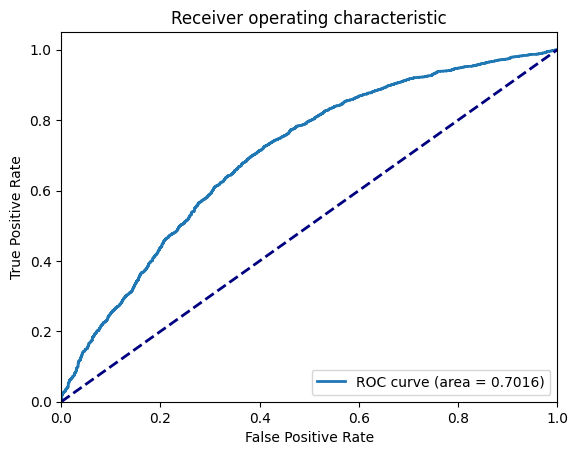

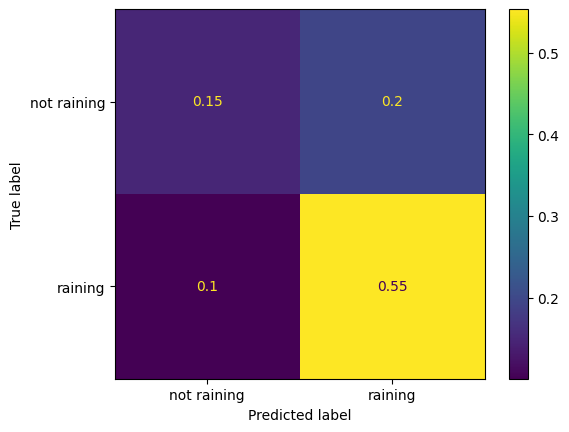

In [15]:
preds = torch.nn.functional.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy()
prediction_probability = preds[:,1]
predictions = preds.argmax(axis=-1)
truth = ds_test.raining.values
plotting.analysis.classification_report(labels=truth, predictions=predictions)
plotting.analysis.plot_roc(truth=truth, prediction_probability=prediction_probability)
plotting.plotting.analysis.check_prediction(truth=truth, prediction=predictions);

As the Hugging Face Classifier class returns predictions after the [logit](https://www.google.com/search?q=logit&client=firefox-b-d&ei=8-IqY5WMGc-Axc8Px9izkAs&ved=0ahUKEwjV0fqr0qX6AhVPQPEDHUfsDLIQ4dUDCA0&uact=5&oq=logit&gs_lcp=Cgdnd3Mtd2l6EAMyBQgAEJECMgUIABCRAjILCC4QgAQQxwEQ0QMyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEOgoIABBHENYEELADOgcIABCwAxBDOgQIABBHSgQIQRgASgQIRhgAULIDWPEGYJULaAFwAngAgAF-iAHOAZIBAzEuMZgBAKABAcgBCMABAQ&sclient=gws-wiz) function, we need to apply a [sigmoid](https://www.google.com/search?q=sigmoid+function&client=firefox-b-d&ei=6-MqY9yuIuqHxc8Pz8-ggAQ&ved=0ahUKEwic0KSi06X6AhXqQ_EDHc8nCEAQ4dUDCA0&uact=5&oq=sigmoid+function&gs_lcp=Cgdnd3Mtd2l6EAMyBQgAEJECMgUIABCRAjIFCAAQkQIyBQgAEJECMgUIABCABDIFCAAQkQIyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEOgoIABBHENYEELADOgcIABCwAxBDOgQIABBDOgsILhCABBDHARDRAzoFCC4QgAQ6CAguEIAEENQCSgQIQRgASgQIRhgAUMIEWOAPYKMQaAJwAXgAgAF2iAHACZIBBDEzLjKYAQCgAQHIAQrAAQE&sclient=gws-wiz) function (binary classification) layer or [softmax](https://www.google.com/search?q=softmax+function&client=firefox-b-d&ei=q-cqY6qzNJySxc8Pu9CNqAs&ved=0ahUKEwjqtJjs1qX6AhUcSfEDHTtoA7UQ4dUDCA0&uact=5&oq=softmax+function&gs_lcp=Cgdnd3Mtd2l6EAMyBAgAEEMyBAgAEEMyBAgAEEMyBAgAEEMyBAgAEEMyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDoKCAAQRxDWBBCwAzoHCAAQsAMQQzoHCAAQgAQQCjoICAAQHhAWEAo6BQgAEIYDOgQIABAKOgQIABANSgQIQRgASgQIRhgAUJYWWIw7YNg7aAxwAXgAgAFoiAHMDJIBBDE5LjGYAQCgAQHIAQrAAQE&sclient=gws-wiz) for multi-class classification, which corresponds to a generalized form of the sigmoid function.

In [16]:
preds = torch.nn.functional.softmax(
    torch.Tensor(trainer.predict(test_ds).predictions)
).numpy()

/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/tmp/ipykernel_28112/3808898392.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.nn.functional.softmax(


## Tasks:
In the following tasks, we will compare our predictions to the ground truth values, which corresponds to our 'raining' field in `ds_tweets`, i.e. `ds_tweets.raining.values`. This field is two-dimensional. However, our predictions are now two dimensional as the sigmoid function converts our predictions into probabilities for either class ("raining", "not raining"). Thus, we obtain our "1D" prediction by using `numpy.argmax`, which returns the index of the maximum value along the axis. We apply this function over the last axis to obtain our 'predictions', i.e. `prediction=preds.argmax(-1)`.
* Plot a confusion matrix of your model's result (use `plotting.analysis.check_prediction` for this).   
    *Note*, using `print(report)` on the returned `report` gives you a nice representation than the default Jupyter Notebook output.
* Plot a ROC curve and compute the AUC.     
    *Hint*, to compute ROC and AUC, we need the prediction probability for our label, i.e. `prediction_probability = preds[:,1]`. 
* Visualize the confidence of the model in its predictions. Use `plotting.analysis.plotting.analysis.plot_predictions_confidence` for this task.
* Retrain the model by changing one or more hyper-parameters as defined in Exercise 5. Change your model output folder `FOLDER_TO_OUTPUT` to load weights later and compare models. To inspire your parameters choice. I list the 'best' hyper-parameters we currently use for our models.
    * learning_rate = 3e-05
    * batch_size = 32
    * weight_decay = 0.01
    * epochs = 1
    * warmup_ratio = 0.45
    * cls_dropout = 0.1
    * lr_scheduler_type = 'linear'   
    
    As an additional challenge, **only change** hyper-parameters if you know what they do. Share your results in class! 
* Visualize your new results.

In [17]:
CHECKPOINT_FOLDER = "checkpoint-2983"

Note, if you just want to evaluate one of your trained models without any further training. You just need to change the model path `model_nm` to the desired checkpoint in your output folder of your saved model `FOLDER_TO_OUTPUT` (Check the contents of the `FOLDER_TO_OUTPUT` to check the specific path). We provide a function here, that combines all required functions into a single function `load_saved_trained_model`. 

In [18]:
# if loading required of saved model
def load_saved_trained_model(ds, folder_to_model, db_config_base, model_nm, parameters):
    # load the pretrained tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(folder_to_model)
    db_config_base = transformers.AutoConfig.from_pretrained(
        folder_to_model, num_labels=2
    )
    dataset = get_dataset(ds, tok_func, tokenizer, indices_train, indices_test)
    trainer = get_trainer(
        dataset, db_config_base, folder_to_model, folder_to_model, parameters
    )
    return trainer


trainer_evaluate = load_saved_trained_model(
    ds_tweets,
    FOLDER_TO_OUTPUT + CHECKPOINT_FOLDER,
    db_config_base,
    model_nm,
    parameters,
)

Map: 100%|██████████| 24491/24491 [00:00<00:00, 27185.50 examples/s]


## Exercise 8: Retrain on full dataset

## Tasks:
* Retrain your best model on the full dataset
* Did you improve your results?
* Analyze the results with the introduced methods in this notebook. Share your results with the group!